# Preparing environment

In [1]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
%aimport holt
%aimport holtwinters
from external import kMedoids
from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())


file_name = "euc_p2_clustering_clean_week_v1.csv"

#printing
pd.options.display.float_format = '{:,.2f}'.format

C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Load preprocessed data

In [5]:
subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)


raw_file_name ="%s_product_p2_raw.csv"%PREFIX
clean_file_name = "%s_product_p2_clean.csv"%PREFIX
z_file_name ="%s_product_z_p2_clean.csv"%PREFIX
clean_full_file_name = "%s_product_p2_clean_full.csv"%PREFIX

clusters_file_name = "euc_p2_clustering_clean_week_v1.csv"
#client_desc = "data_client_bnd_ita2.csv"

row_headers = ['Product']
n_row_headers = len(row_headers)



product_raw_df = pd.read_csv(interim_path+raw_file_name, sep=';', encoding='utf-8')
product_df = pd.read_csv(interim_path+clean_file_name, sep=';', encoding='utf-8')
product_df_full = pd.read_csv(processed_path+z_file_name, sep=';', encoding='utf-8')
product_df_clean = pd.read_csv(interim_path+clean_full_file_name, sep=';', encoding='utf-8')

X_z = product_df_full.values[:,n_row_headers:].astype(np.float64)



nb_col = X_z.shape[1]
X_pca = PCA(n_components = nb_col).fit_transform(X_z)

print(product_df_full.shape)
product_df_clean.head()

(7570, 103)


,Product,04/01/2015,03/01/2016,10/01/2016,17/01/2016,24/01/2016,31/01/2016,07/02/2016,14/02/2016,21/02/2016,...,22/10/2017,29/10/2017,05/11/2017,12/11/2017,19/11/2017,26/11/2017,03/12/2017,10/12/2017,17/12/2017,24/12/2017
0,30E0001004404,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.00,4.00,12.00,12.00,6.00,12.00,2.00,30.00,6.00,8.00
1,30E0001005604,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.00,26.00,34.00,14.00,18.00,28.00,30.00,46.00,16.00,16.00
2,30E0001007004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.00,28.00,48.00,38.00,16.00,30.00,26.00,38.00,20.00,34.00
3,30E0002001404,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.00,10.00,26.00,12.00,16.00,14.00,28.00,18.00,18.00,22.00
4,30E0002005604,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,30.00,10.00,44.00,28.00,8.00,48.00,20.00,42.00,12.00,16.00


In [14]:
clusters = pd.read_csv(models_path+clusters_file_name, sep=';', encoding='utf-8').drop('Unnamed: 0',axis=1).drop(["Centroid"],axis=1)#
products = product_df_clean.set_index(row_headers)


# clients = pd.read_csv(raw_path+client_desc, sep=';', encoding='iso8859_2').fillna("NA")[["Key_lvl4","Key_lvl5"]].drop_duplicates().set_index("Key_lvl4")

    
# keys = pd.merge(clusters,clients,how="inner",left_on=["Client"],right_index=True).set_index(['Product','Client'])
keys = clusters.set_index(row_headers)


series = products.join(keys,how="inner")

#rearange columns
#series = series[['Key_lvl5','Cluster'] + [c for c in series if c not in ['Cluster','Key_lvl5']]]
series = series[['Cluster'] + [c for c in series if c not in ['Cluster']]]

print(series.shape)
series.head()

group_series = series.groupby(['Cluster']).sum().astype(int)

group_series.tail()

(7570, 106)


,04/01/2015,03/01/2016,10/01/2016,17/01/2016,24/01/2016,31/01/2016,07/02/2016,14/02/2016,21/02/2016,28/02/2016,...,22/10/2017,29/10/2017,05/11/2017,12/11/2017,19/11/2017,26/11/2017,03/12/2017,10/12/2017,17/12/2017,24/12/2017
Cluster,,,,,,,,,,,,,,,,,,,,,
39,0,258,348,394,774,1996,3640,3680,5274,31196,...,3964,4712,3656,3064,1418,416,346,338,380,270
40,0,2,14,38,20,46,40,46,16,80,...,24,38,10,6,0,0,2,2,0,2
41,0,83440,96688,105826,146192,222592,92936,70248,52940,29238,...,712,640,624,456,406,270,664,464,100,108
42,0,32,16,32,30,24,8,60,124,18,...,13694,12520,17306,16254,12382,9666,10054,5024,1464,1156
43,0,1530,1574,1390,1992,4610,8710,10546,19130,65136,...,774,962,786,1572,704,376,252,54,90,20


## Holt-Winter's Models

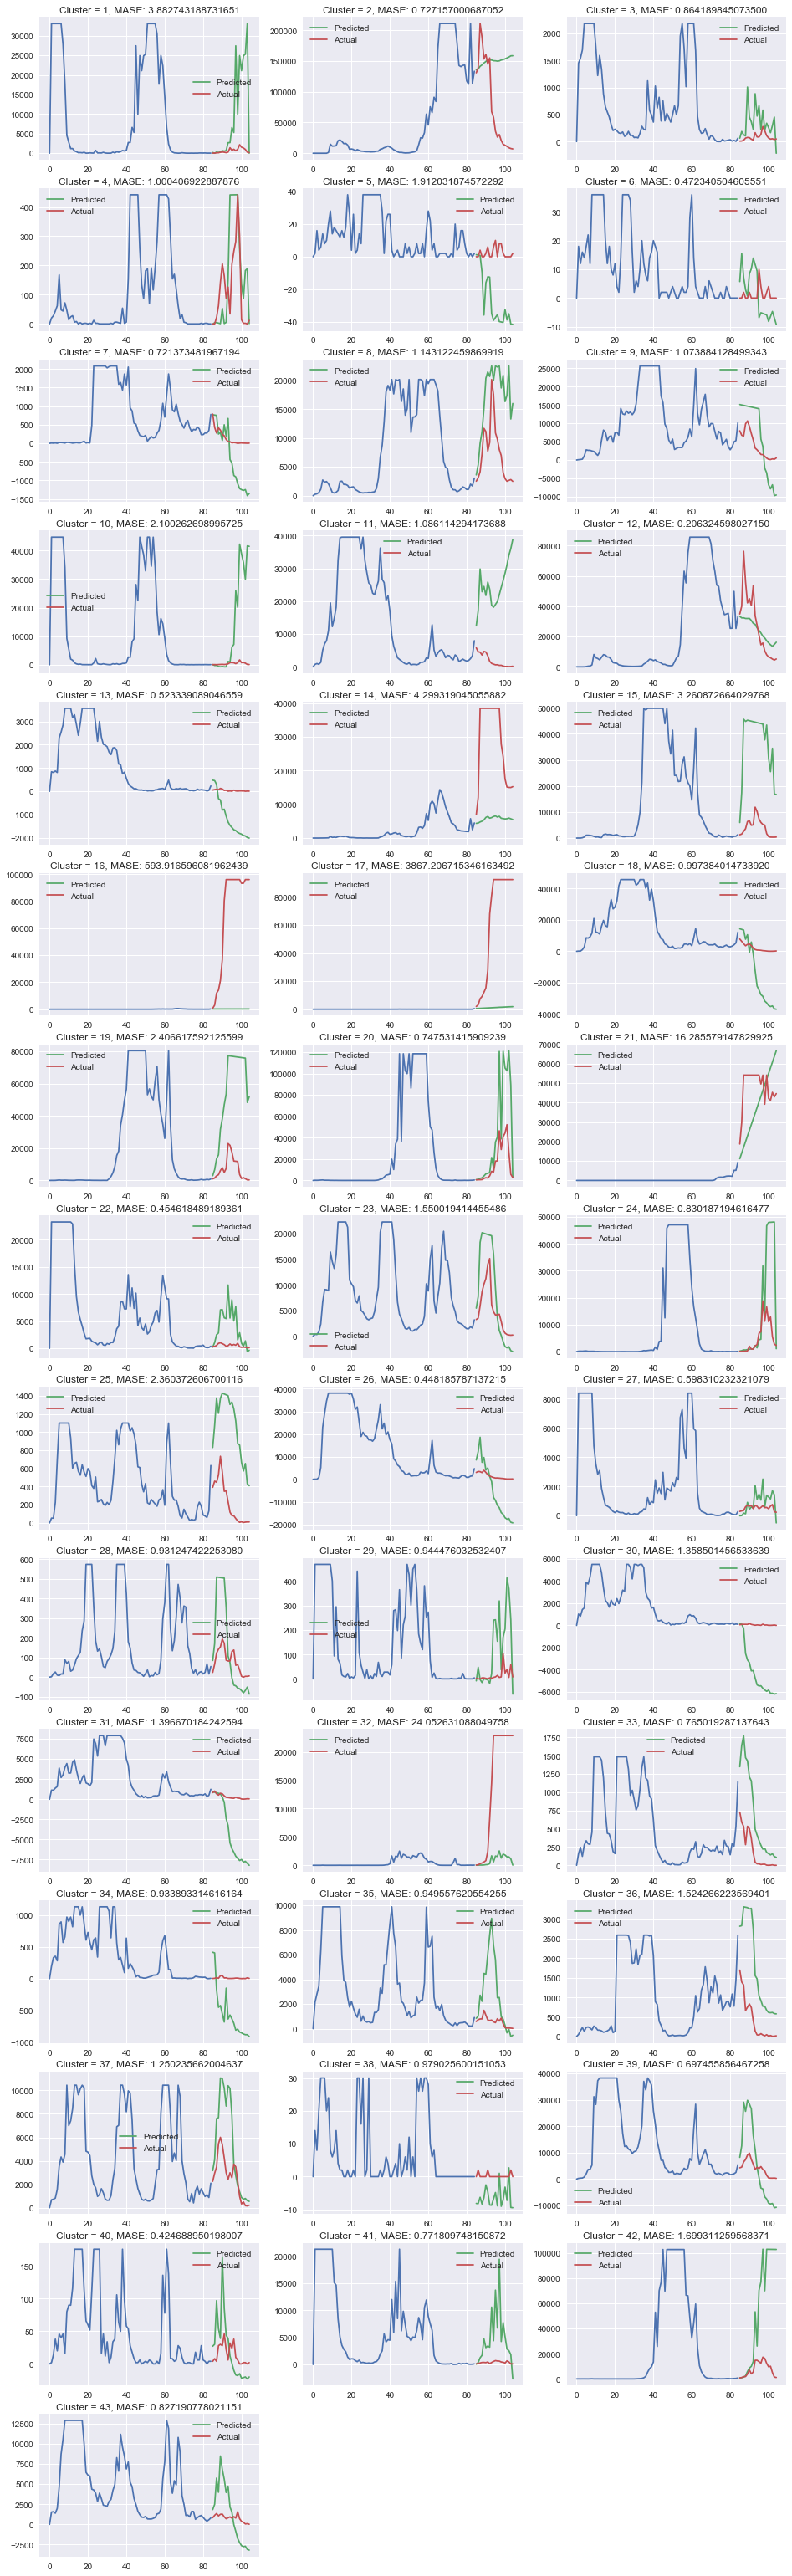

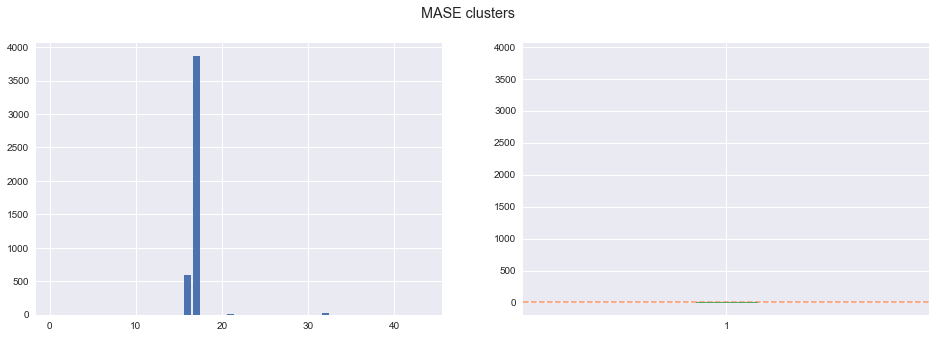

[11 39 25 21  5 12 26 38  6  1 19 32 40 42 23  2 27 33 28 34 37 17  3  8 10
  7 36 29 30 35 22 41  4  9 24 18 14  0 13 20 31 15 16]


In [11]:
import statsmodels.tsa.api as sm
import holtwinters as hw
from math import sqrt



def MASE_analysis(mase,**kwargs):    
    plt.figure(figsize=(16,5))
    plt.suptitle(kwargs["title"])
    plt.subplot(1,2,1)
    plt.bar(np.arange(n_clusters)+1,MASE)
    plt.subplot(1,2,2)
    plt.boxplot(mase)
    plt.axhline(y=1,c='lightsalmon',ls='--')


seasonality = [52]
fc=20

n_clusters = group_series.shape[0]

def grid_forecast(series,seasonality_length,forecast):
    preds = []
    errors = np.zeros((len(seasonality_length)))
    for i,m in enumerate(seasonality_length):
        dexp,a,b,g,rmse = hw.additive(list(series[:-forecast]),m,forecast)
        preds.append(dexp)
        errors[i] = rmse
    min_error = np.argmin(errors)
    return preds[min_error],seasonality_length[min_error]


plt.figure(figsize=(16,150))
forecasts = np.zeros((n_clusters,fc)).astype(np.float64)
MASE = []
RMSE = []
for cluster,serie in group_series[:].iterrows():
    #winsorizing series
    serie = pd.DataFrame(serie).apply(mstats.winsorize,limits = (None,0.1)).values  
    #days to forecast
    l=len(serie) 

    pred,m = grid_forecast(serie,seasonality,fc)
    
    forecasts[cluster-1] = pred

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(serie[-fc:], pred)]) / fc)
    
    train_series = np.ravel(serie[:-fc])
    mase = hw.MASE(train_series,serie[-fc:],pred,m)
    MASE.append(mase)
    RMSE.append(rmse)
    
    
    plt.subplot(40,3,cluster)
    plt.title("Cluster = %d, MASE: %.15f"%(cluster,mase))
    plt.plot(range(0,l-fc),serie[:-fc])
    plt.plot(range(l-fc,l),pred,label="Predicted")
    plt.plot(range(l-fc,l),serie[-fc:],label="Actual")
    plt.legend()


MASE_analysis(MASE,title="MASE clusters")
plt.show()
print(np.argsort(MASE))   
# plt.figure()
# plt.boxplot(serie[:],sym='b.')

forecast = pd.DataFrame(forecasts,columns = group_series.columns[-fc:],index = group_series.index)



## Split and error calculation

In [13]:
split_MASE = [None for x in range(n_clusters+1)]
forecast_MASE = [None for x in range(n_clusters+1)]
MASE_var = []
c=18
for cluster,c_pred in forecast[:].iterrows():
    splits = series[series["Cluster"]==cluster]
    c_serie = group_series.loc[cluster].values
    n_splits = splits.shape[0]
    i=0
    split_MASE[cluster] = []
    forecast_MASE[cluster] = []


    for index,split in splits.iterrows():
        serie = split.values[1:]
        weighted = serie[:-fc].sum()/c_serie[:-fc].sum()
        pred = c_pred * weighted
        
        fcst,m = grid_forecast(serie,seasonality,fc)
        
        train_series = np.ravel(serie[:-fc])
        split_mase = hw.MASE(train_series,serie[-fc:],pred,m)
        fcst_mase = hw.MASE(train_series,serie[-fc:],fcst,m)
        
        split_MASE[cluster].append(split_mase)
        forecast_MASE[cluster].append(fcst_mase)
        

    agg = MASE[cluster-1]

    split = np.array(split_MASE[cluster]).mean()
    fcst = np.array(forecast_MASE[cluster]).mean()
    increase = (split-agg)/(agg)*100
    bias = (split-fcst)/(fcst)*100
    MASE_var.append([agg,split,fcst,increase,bias])
    accuracy = (split-fcst)/(fcst)
    if increase<0.2 and False:
        MASE_analysis(split_MASE[cluster],title="Cluster %d split:%.2f , agg:%.2f *** Increase %.2f %%"%(cluster,split,agg,increase*100))


C:\Users\rahmim00\Documents\Notebooks\Clustering\pc_clustering\notebooks\Cerf7\..\..\src\holtwinters.py:249: RuntimeWarning: divide by zero encountered in double_scalars
  return errors.mean()/d
C:\Users\rahmim00\Documents\Notebooks\Clustering\pc_clustering\notebooks\Cerf7\..\..\src\holtwinters.py:249: RuntimeWarning: invalid value encountered in double_scalars
  return errors.mean()/d
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


## Split forecast Analysis

In [15]:
mase_variation = pd.DataFrame(MASE_var,index = range(1,n_clusters+1),columns=["Agg","Split","Forecast","Increase","Bias"])
display(mase_variation.describe())
plt.figure(figsize=(16,5))
plt.suptitle("Error distribution")
plt.subplot(1,2,1)
plt.boxplot(mase_variation.Increase.values,sym='k.')
plt.axhline(y=0,c='lightsalmon',ls='--')
plt.subplot(1,2,2)
plt.hist(mase_variation.Increase)
plt.axvline(x=0,c='lightsalmon',ls='--')

plt.figure(figsize=(16,5))
plt.suptitle("Bias distribution")
plt.subplot(1,2,1)
plt.boxplot(mase_variation.Bias.values,sym='k.')
plt.axhline(y=0,c='lightsalmon',ls='--')
plt.subplot(1,2,2)
plt.hist(mase_variation.Bias)
plt.axvline(x=0,c='lightsalmon',ls='--')


print("Increased Forecast quality: %.2f%%"%inc_perc)
print("Decreased Forecast quality: %.2f%%"%dec_perc)
print("Good Forecast quality: %.2f%%"%good_perc)
print("Better than detail Forecast quality: %.2f%%"%better_perc)

decrease = mase_variation.Increase<=0
increase = mase_variation.Increase>0
better = mase_variation.Bias<=0
good_splits = (mase_variation.Split<0.75) | (mase_variation.Increase<23)

inc_perc = int(mase_variation[decrease].count()[0])/n_clusters * 100
dec_perc = int(mase_variation[increase].count()[0])/n_clusters * 100
better_perc = int(mase_variation[better].count()[0])/n_clusters * 100
good_perc = mase_variation[good_splits].shape[0]/n_clusters * 100



display(mase_variation[good_splits].sort_values(by=["Agg"]).head())



plt.show()



,Agg,Split,Forecast,Increase,Bias
count,43.00,43.00,39.00,43.00,26.00
mean,105.83,inf,inf,inf,-44.30
std,594.17,nan,nan,nan,22.76
min,0.21,0.11,0.30,-89.23,-84.87
25%,0.76,0.39,0.72,-51.07,-60.11
50%,1.00,0.74,1.22,-18.48,-46.85
75%,1.81,inf,inf,inf,-25.03
max,"3,867.21",inf,inf,inf,-8.70


ValueError: range parameter must be finite.

## Display forecasting on splits

Cluster 99 split:0.46 , agg:0.42 *** Increase 9.42 %


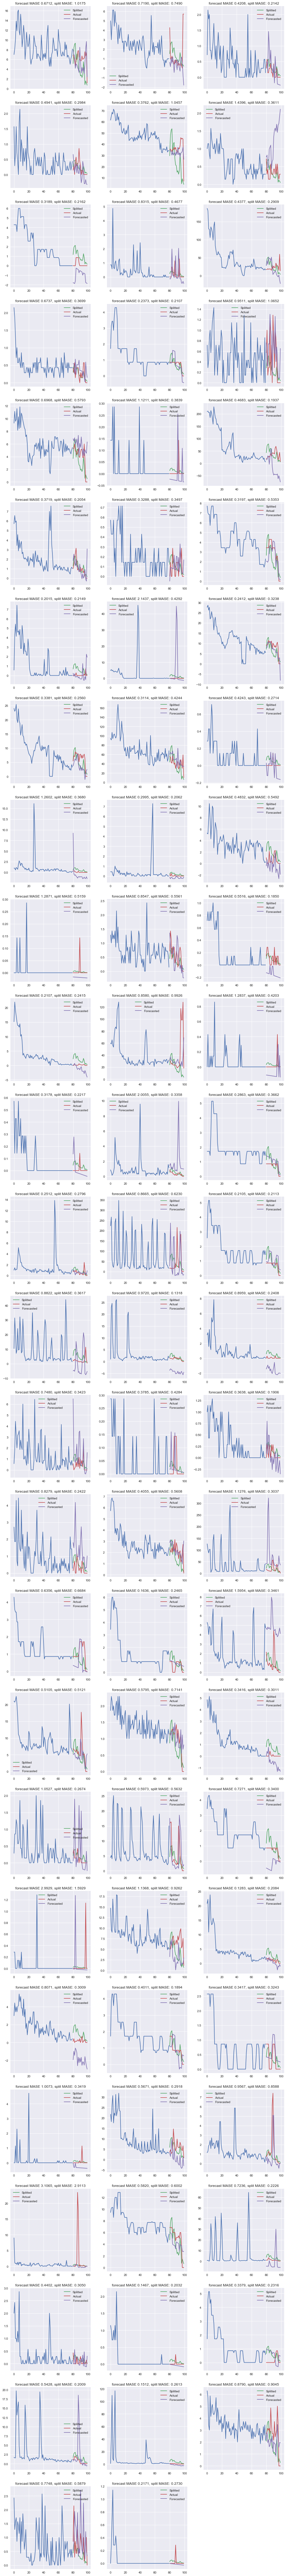

In [119]:
cluster = 99

splits = series[series["Cluster"]==cluster]
c_serie = group_series.loc[cluster].values
c_pred = forecast.loc[cluster].values
n_splits = splits.shape[0]
i=0
split_MASE= []
forecast_MASE= []

plt.figure(figsize=(16,2*n_splits))
rows = n_splits/3.0+1

for index,split in splits.iterrows():
    serie = split.values[1:]
    weighted = serie[:-fc].sum()/c_serie[:-fc].sum()
    pred = c_pred * weighted

    fcst,m = grid_forecast(serie,seasonality,fc)

    train_series = np.ravel(serie[:-fc])
    
    split_mase = hw.MASE(train_series,serie[-fc:],pred,m)
    fcst_mase = hw.MASE(train_series,serie[-fc:],fcst,m)
    
    split_MASE.append(split_mase)
    forecast_MASE.append(fcst_mase)
    i+=1
    plt.subplot(rows,3,i)
    plt.title("forecast MASE %.04f, split MASE: %.04f"%(fcst_mase,split_mase))
    plt.plot(range(0,l-fc),serie[:-fc],label=None)
    plt.plot(range(l-fc,l),pred,label="Splitted")        
    plt.plot(range(l-fc,l),serie[-fc:],label="Actual")
    plt.plot(range(l-fc,l),fcst,label="Forecasted")
    plt.legend()

agg = MASE[cluster-1]
split = np.array(split_MASE).mean()
fcst = np.array(forecast_MASE).mean()
increase = (split-agg)/(agg)
accuracy = (split-fcst)/(fcst)

print("Cluster %d split:%.2f , agg:%.2f *** Increase %.2f %%"%(cluster,split,agg,increase*100))
    
plt.show()

## Seasonal Decompose

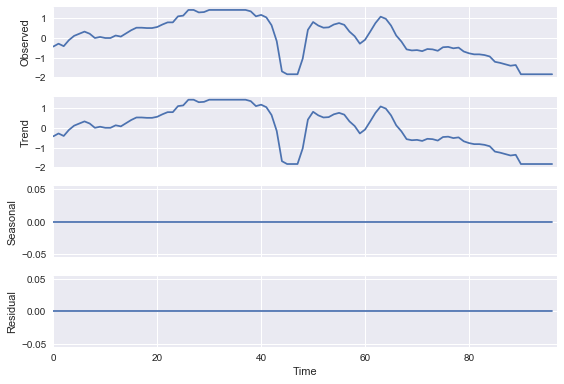

In [51]:
import statsmodels.api as sm

serie = series.iloc[5].values[1:]

res = sm.tsa.seasonal_decompose(s,freq=1,model='a')
resplot = res.plot()
plt.show()


### ARIMA Models

In [29]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot





l=20
s = product_df_full.loc[l].values[2:].astype(float)

# product_df_full.loc[l,product_df_full.columns[1:]].plot(kind='kde')
# plt.show()

# model = ARIMA(s, order=(0, 2, 2))
# results_ARIMA = model.fit(disp=-1, trend='nc',method = 'css-mle')#start_params=(2,2)   

# dim = X_z.shape[1]
# new_dim = results_ARIMA.fittedvalues.shape[0]


plt.figure(figsize=(16,150))
for cluster,serie in group_series.iterrows():
    #winsorizing series
    serie = pd.DataFrame(serie).apply(mstats.winsorize,limits = (None,0.075)).values  
    #days to forecast
    fc=20
    l=len(serie) 

    pred,m = grid_forecast(serie,seasonality,fc)

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(serie[-fc:], pred)]) / fc)
    
    train_series = np.ravel(serie[:-fc])
    mase = hw.MASE(train_series,serie[-fc:],pred,1)
    
    if mase<1.2: continue
    plt.subplot(40,3,cluster)
    plt.title("M = %d, MASE: %.15f"%(m,mase))
    plt.plot(range(0,l-fc),serie[:-fc])
    plt.plot(range(l-fc,l),pred,label="Predicted")
    plt.plot(range(l-fc,l),serie[-fc:],label="Actual")
    plt.legend()


plt.show()






KeyboardInterrupt: 